# Model comparison
Natalia Vélez, March 2022

In [48]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import teaching_models as teach
from os.path import join as opj
from scipy.spatial import distance
from ast import literal_eval

sys.path.append('..')
from utils import read_json, gsearch, str_extract, int_extract

sns.set_style('white')
sns.set_context('talk')

## I. Model recovery on simulated data

Find model recovery files:

In [2]:
model_files = gsearch('outputs/simulated_model_comparison/*pxp.txt')
model_files.sort()
print(*model_files, sep='\n')

outputs/simulated_model_comparison/model-cost_pxp.txt
outputs/simulated_model_comparison/model-info_cost_pxp.txt
outputs/simulated_model_comparison/model-info_pref_cost_pxp.txt
outputs/simulated_model_comparison/model-info_pref_pxp.txt
outputs/simulated_model_comparison/model-info_pxp.txt
outputs/simulated_model_comparison/model-pref_cost_pxp.txt
outputs/simulated_model_comparison/model-pref_pxp.txt


Data wrangling

In [3]:
pxp_list = []
model_levels = ['info_pref_cost', 'info_pref', 'info_cost', 'pref_cost', 'info', 'pref', 'cost', 'strong']
for f in model_files:
    pxp = np.loadtxt(f,delimiter=',')

    label_f = f.replace('pxp', 'model_labels')
    labels = np.loadtxt(label_f, dtype=str)

    f_df = pd.DataFrame(list(zip(labels, pxp)), columns=['fit_model', 'pxp'])
    f_df['true_model'] = str_extract('(?<=model-).+(?=_pxp)', f)
    
    pxp_list.append(f_df)
    
pxp_df = pd.concat(pxp_list)
print(pxp_df.shape)
pxp_df.head()

(49, 3)


,fit_model,pxp,true_model
0,cost,9.999990e-01,cost
1,info,2.570922e-14,cost
2,info_cost,2.570922e-14,cost
3,info_pref,2.570922e-14,cost
4,info_pref_cost,2.570922e-14,cost


Make confusion matrix

[Text(0.5, 3.296875, 'True model'),
 Text(71.69687500000006, 0.5, 'Predicted model')]

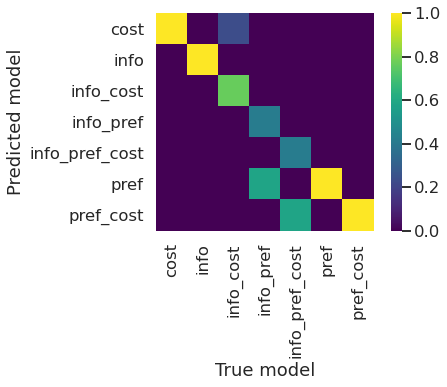

In [4]:
confusion_mtx = pxp_df.pivot(index='fit_model', columns='true_model', values='pxp')
ax = sns.heatmap(confusion_mtx, cmap='viridis', square=True)
ax.set(xlabel='True model', ylabel='Predicted model')

## II. Model comparison on human data

### Which model best captures human behavior?

Read model evidence file:

In [5]:
human_pxp = np.loadtxt('outputs/human_model_comparison/human_model_pxp.txt', delimiter=',')
human_labels = np.loadtxt('outputs/human_model_comparison/model_labels.txt', dtype=str)

human_df = pd.DataFrame({'model': human_labels, 'pxp': human_pxp})
human_df['model'] = human_df['model'].astype('category').cat.reorder_categories(model_levels)
human_df = human_df.sort_values(by='model').reset_index(drop=True)

human_df

,model,pxp
0,info_pref_cost,0.459090
1,info_pref,0.000005
2,info_cost,0.000001
3,pref_cost,0.540896
4,info,0.000002
5,pref,0.000002
6,cost,0.000002
7,strong,0.000002


Read probability that each model generated each teacher:

In [6]:
# read posterior
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
human_posterior = pd.read_table('outputs/human_model_comparison/human_model_posterior.txt', sep=',', names=human_labels)
human_posterior['subject'] = subjects

# tally winning model
human_posterior['winner'] = np.where(human_posterior.info_pref_cost > human_posterior.pref_cost, 'info_pref_cost', 'pref_cost')
winning_models = human_posterior[['subject', 'winner']]
winning_models.groupby('winner').agg({'subject': 'nunique'})

,subject
winner,
info_pref_cost,14
pref_cost,14


### Do info vs. non-info participants behave in qualitatively different ways? 

#### Do they pick different examples? 

Classify behavioral data based on the winning model:

In [23]:
behav_df = teach.human_df.copy().merge(winning_models)
behav_df['cursor_coords'] = behav_df['cursor_coords'].apply(literal_eval)
behav_df[['cursor_coords', 'example_coords']] = behav_df[['cursor_coords', 'example_coords']]
behav_df.head()

,subject,run,block_idx,ex_idx,first_movement,start,problem,order,example,cursor_coords,example_coords,cursor,winner
0,1,1,0,0,"[0, 1]","[0, 0]",22,"['C', 'B', 'D', 'A']",8,"[0, 0]","[1, 2]",0,pref_cost
1,1,1,0,1,"[0, 1]","[0, 0]",22,"['C', 'B', 'D', 'A']",27,"[1, 2]","[4, 3]",8,pref_cost
2,1,1,1,0,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",3,"[0, 5]","[0, 3]",5,pref_cost
3,1,1,1,1,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",32,"[0, 3]","[5, 2]",3,pref_cost
4,1,1,1,2,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",7,"[5, 2]","[1, 1]",32,pref_cost


Average examples selected by each group:

In [8]:
avg_examples = behav_df.groupby(['winner', 'problem', 'example']).agg({'subject': 'count'}).reset_index()
avg_examples['freq'] = avg_examples.subject/avg_examples.groupby('problem').subject.transform('sum')

avg_examples.head()

,winner,problem,example,subject,freq
0,info_pref_cost,0,2,11,0.139241
1,info_pref_cost,0,3,7,0.088608
2,info_pref_cost,0,7,1,0.012658
3,info_pref_cost,0,10,2,0.025316
4,info_pref_cost,0,12,3,0.037975


Plot average examples:

Text(0.5, 0.98, 'Problem 23')

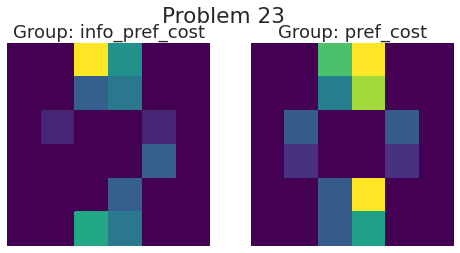

In [9]:
prob_idx = 23
prob_data = avg_examples[avg_examples.problem == prob_idx].copy()

fig,axes=plt.subplots(1,2, figsize=(8,4))
ax_counter = 0

for name, group in prob_data.groupby('winner'):
    v = np.zeros(36)
    v[group.example] = group.freq
    
    ex_mtx = np.reshape(v, (6,6))
    sns.heatmap(ex_mtx, square=True, cbar=False, cmap='viridis', ax=axes[ax_counter])
    axes[ax_counter].set(xticklabels=[], yticklabels=[], title='Group: %s' % name)
    ax_counter += 1
    
fig.suptitle('Problem %i' % prob_idx)

Distance between successive examples:

### Sanity-check: Do non-info participants have info weights near 0? 

Read parameter files:

In [51]:
param_files = gsearch('outputs/fit_model-info_pref_cost_method-optimize/*.json')
param_files.sort()

param_list = []

for f in param_files:
    res = read_json(f) # read model-fitting results
    
    sub = int_extract('(?<=sub-)[0-9]{2}', f) # assemble df with MLE
    sub_df = pd.DataFrame([[sub]+res['x']], columns=['subject', 'info', 'pref', 'cost'])
    param_list.append(sub_df)
    
param_df = pd.concat(param_list).reset_index(drop=True)
param_df = param_df.merge(winning_models)

print(param_df.shape)
param_df.head()

(28, 5)


,subject,info,pref,cost,winner
0,1,0.086825,26.920775,2.759949,pref_cost
1,2,0.011269,11.780821,2.979073,pref_cost
2,4,1.330218,22.698957,4.022790,info_pref_cost
3,5,0.202545,8.802126,2.547528,pref_cost
4,6,0.058067,31.324121,2.767836,pref_cost


In [ ]:
g = sns.displot(data=param_df, x='info', hue='winner')
g.legend.set_title('Winning model')
g.set_axis_labels(x_var=r'$\omega_{info}$ (full model)')

In [64]:
?g.set_axis_labels

Signature: g.set_axis_labels(x_var=None, y_var=None, clear_inner=True, **kwargs)
Docstring: Set axis labels on the left column and bottom row of the grid.
File:      /n/helmod/apps/centos7/Core/Anaconda3/2020.11-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/axisgrid.py
Type:      method


In [66]:
print(r'$\omega_{\text{info}}$')

$\omega_{\text{info}}$
